In [1]:
import os
os.chdir("/Coding/Spectrum4Geo/") #Change to ProjectDirectory (One Directory above)

In [2]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize
from dataclasses import dataclass
import os
import numpy as np

from spectrum4geo.dataset.soundingearth import SoundingEarthDatasetEval, SoundingEarthDatasetTrain
from torch.utils.data import DataLoader
from spectrum4geo.transforms import get_transforms_train_sat, get_transforms_train_spectro 
from spectrum4geo.transforms import get_transforms_val_sat, get_transforms_val_spectro 



@dataclass
class Configuration:
    img_size: int = 384         # for satallite images
    patch_time_steps = 24576//3//3    # Image size for spectograms (Width)
    n_mels = 128                # image size for spectograms (Height)
    sr_kHz = 48
    batch_size: int = 48        # keep in mind real_batch_size = 2 * batch_size
    data_folder = "data"        # Dataset
    # Augment Images
    prob_rotate: float = 0.75          # rotates the sat image 
    prob_flip: float = 0.5             # flipping the sat image 
    num_workers: int = 0 if os.name == 'nt' else 4 
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu' 
    mean=[1, 1, 1]
    std=[1, 1, 1]
    

config = Configuration()

img_size = config.img_size
img_size_sat = (img_size, img_size)
img_size_spectro = (config.patch_time_steps, config.n_mels)

# Transforms
sat_transforms_train = get_transforms_train_sat(img_size_sat,
                                                    mean=config.mean,
                                                    std=config.std,
                                                    )

spectro_transforms_train = get_transforms_train_spectro(img_size_spectro,
                                                            mean=config.mean,
                                                            std=config.std,
                                                            )


train_dataset = SoundingEarthDatasetTrain(data_folder=config.data_folder ,
                                          split_csv='train_df.csv',
                                          transforms_sat_image=sat_transforms_train,
                                          transforms_spectrogram=spectro_transforms_train,
                                          patch_time_steps=config.patch_time_steps,
                                          sr_kHz=config.sr_kHz,
                                          n_mels=config.n_mels,
                                          prob_flip=config.prob_flip,
                                          prob_rotate=config.prob_rotate,
                                          shuffle_batch_size=config.batch_size
                                          )


train_dataloader = DataLoader(train_dataset,
                              batch_size=12,  
                              shuffle=True,
                              num_workers=config.num_workers,
                              pin_memory=True)


# Eval
sat_transforms_val = get_transforms_val_sat(img_size_sat,
                                                mean=config.mean,
                                                std=config.std,
                                                )

spectro_transforms_val = get_transforms_val_spectro(mean=config.mean,       
                                                        std=config.std
                                                        )    

# Reference Satellite Images
sat_dataset_test = SoundingEarthDatasetEval(data_folder=config.data_folder ,
                                    split_csv='test_df.csv',
                                    query_type = "sat",
                                    transforms=sat_transforms_val,
                                    patch_time_steps=config.patch_time_steps,
                                    sr_kHz=config.sr_kHz,
                                    n_mels=config.n_mels,
                                    )

sat_dataloader_test = DataLoader(sat_dataset_test,
                                        batch_size=config.batch_size,
                                        num_workers=config.num_workers,
                                        shuffle=False,
                                        pin_memory=True)
    
    

# Reference Spectogram Images
spectro_dataset_test = SoundingEarthDatasetEval(data_folder=config.data_folder ,
                                    split_csv='test_df.csv',
                                    query_type = "spectro",
                                    transforms=spectro_transforms_val,
                                    patch_time_steps=config.patch_time_steps,
                                    sr_kHz=config.sr_kHz,
                                    n_mels=config.n_mels,
                                    )

spectro_dataloader_test = DataLoader(spectro_dataset_test,
                                    batch_size=config.batch_size,
                                    num_workers=config.num_workers,
                                    shuffle=False,
                                    pin_memory=True)


print("Reference (Sat) Images Test:", len(sat_dataset_test))
print("Reference (Spectro) Images Test:", len(spectro_dataset_test))
    
dataloader_val_tup = (spectro_dataloader_test, sat_dataloader_test)

/home/j0kr0017/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/j0kr0017/conda/lib/python3.12/site-packages/pydantic/main.py:328: UserWarning: Pydantic serializer warnings:
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  Expected `Union[float, tuple[float, float]]` but got `list` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Reference (Sat) Images Test: 10179
Reference (Spectro) Images Test: 10179


Plotte Train Dataloader Bilder

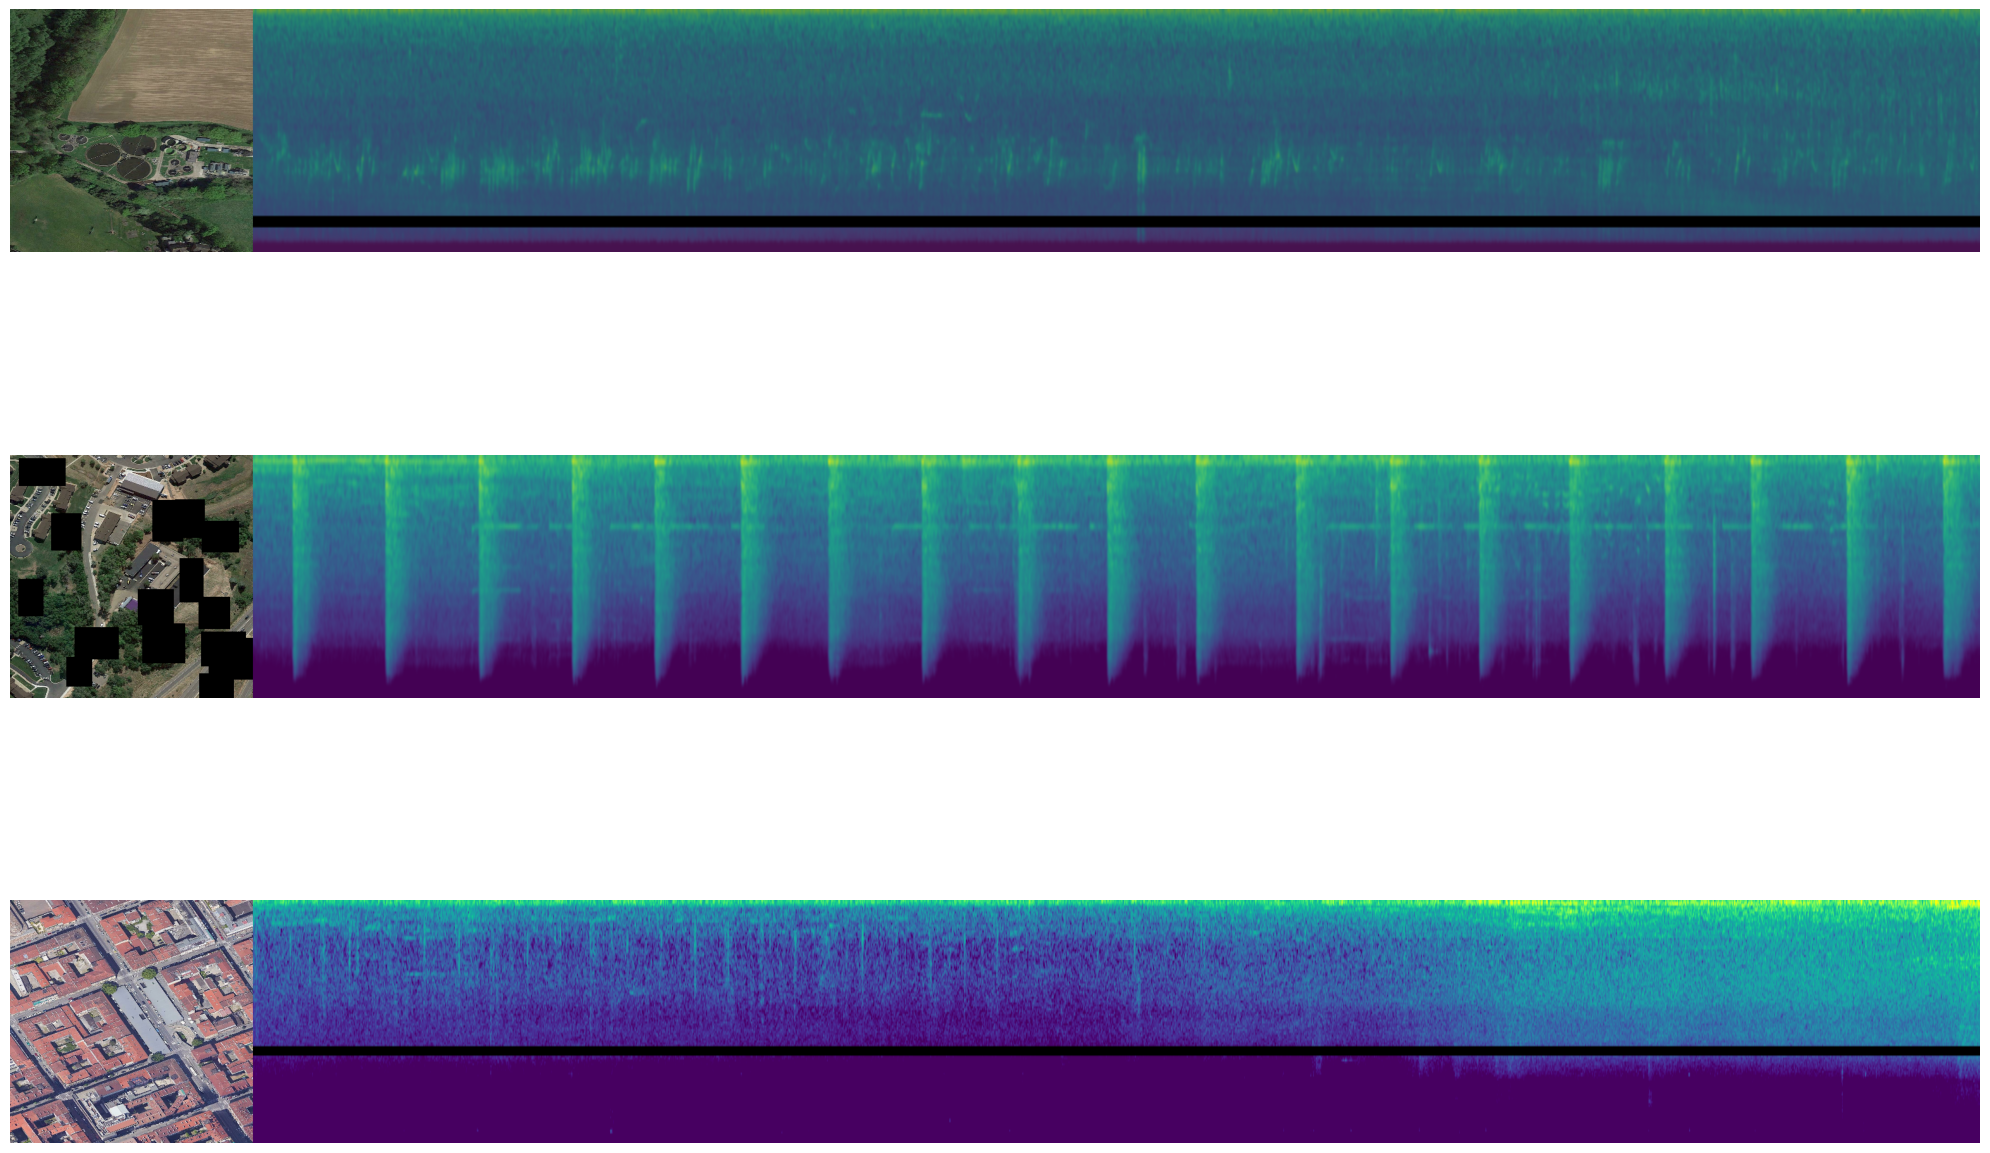

In [3]:
def denormalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

def plot_images(dataloader, num_images,  spectro_den_b = True, sat_den_b = True):
    fig, axs = plt.subplots(nrows=num_images, ncols=1, figsize=(20, 5 * num_images))  
    axs = axs.flatten() 

    image_count = 0
    for data in dataloader:
        sat_images, spectrograms, _ = data  

        for sat_image, spectrogram in zip(sat_images, spectrograms):
            if image_count >= num_images:
                break

            if sat_den_b:
                sat_image = denormalize(sat_image, config.mean, config.std)
            if spectro_den_b:
                spectrogram = denormalize(spectrogram, config.mean, config.std)
                #spectrogram = (spectrogram + )    # to convert 

            target_height = sat_image.shape[1]  
            spectrogram_resized = resize(spectrogram, (target_height, spectrogram.shape[-1]))

            combined_image = torch.cat((sat_image, spectrogram_resized), dim=2)  

            ax = axs[image_count]
            ax.imshow(combined_image.permute(1, 2, 0).numpy())  
            ax.axis('off')  
            image_count += 1

        if image_count >= num_images:
            break

    plt.tight_layout()
    plt.show()

plot_images(train_dataloader, 3, spectro_den_b = True, sat_den_b = True)

Plotte Eval Dataloader Bilder

Spalte: 1, Reihe0, Satellite: 2915, Spectrogram: 2915
Spalte: 0, Reihe1, Satellite: 49939, Spectrogram: 49939
Spalte: 1, Reihe1, Satellite: 8484, Spectrogram: 8484


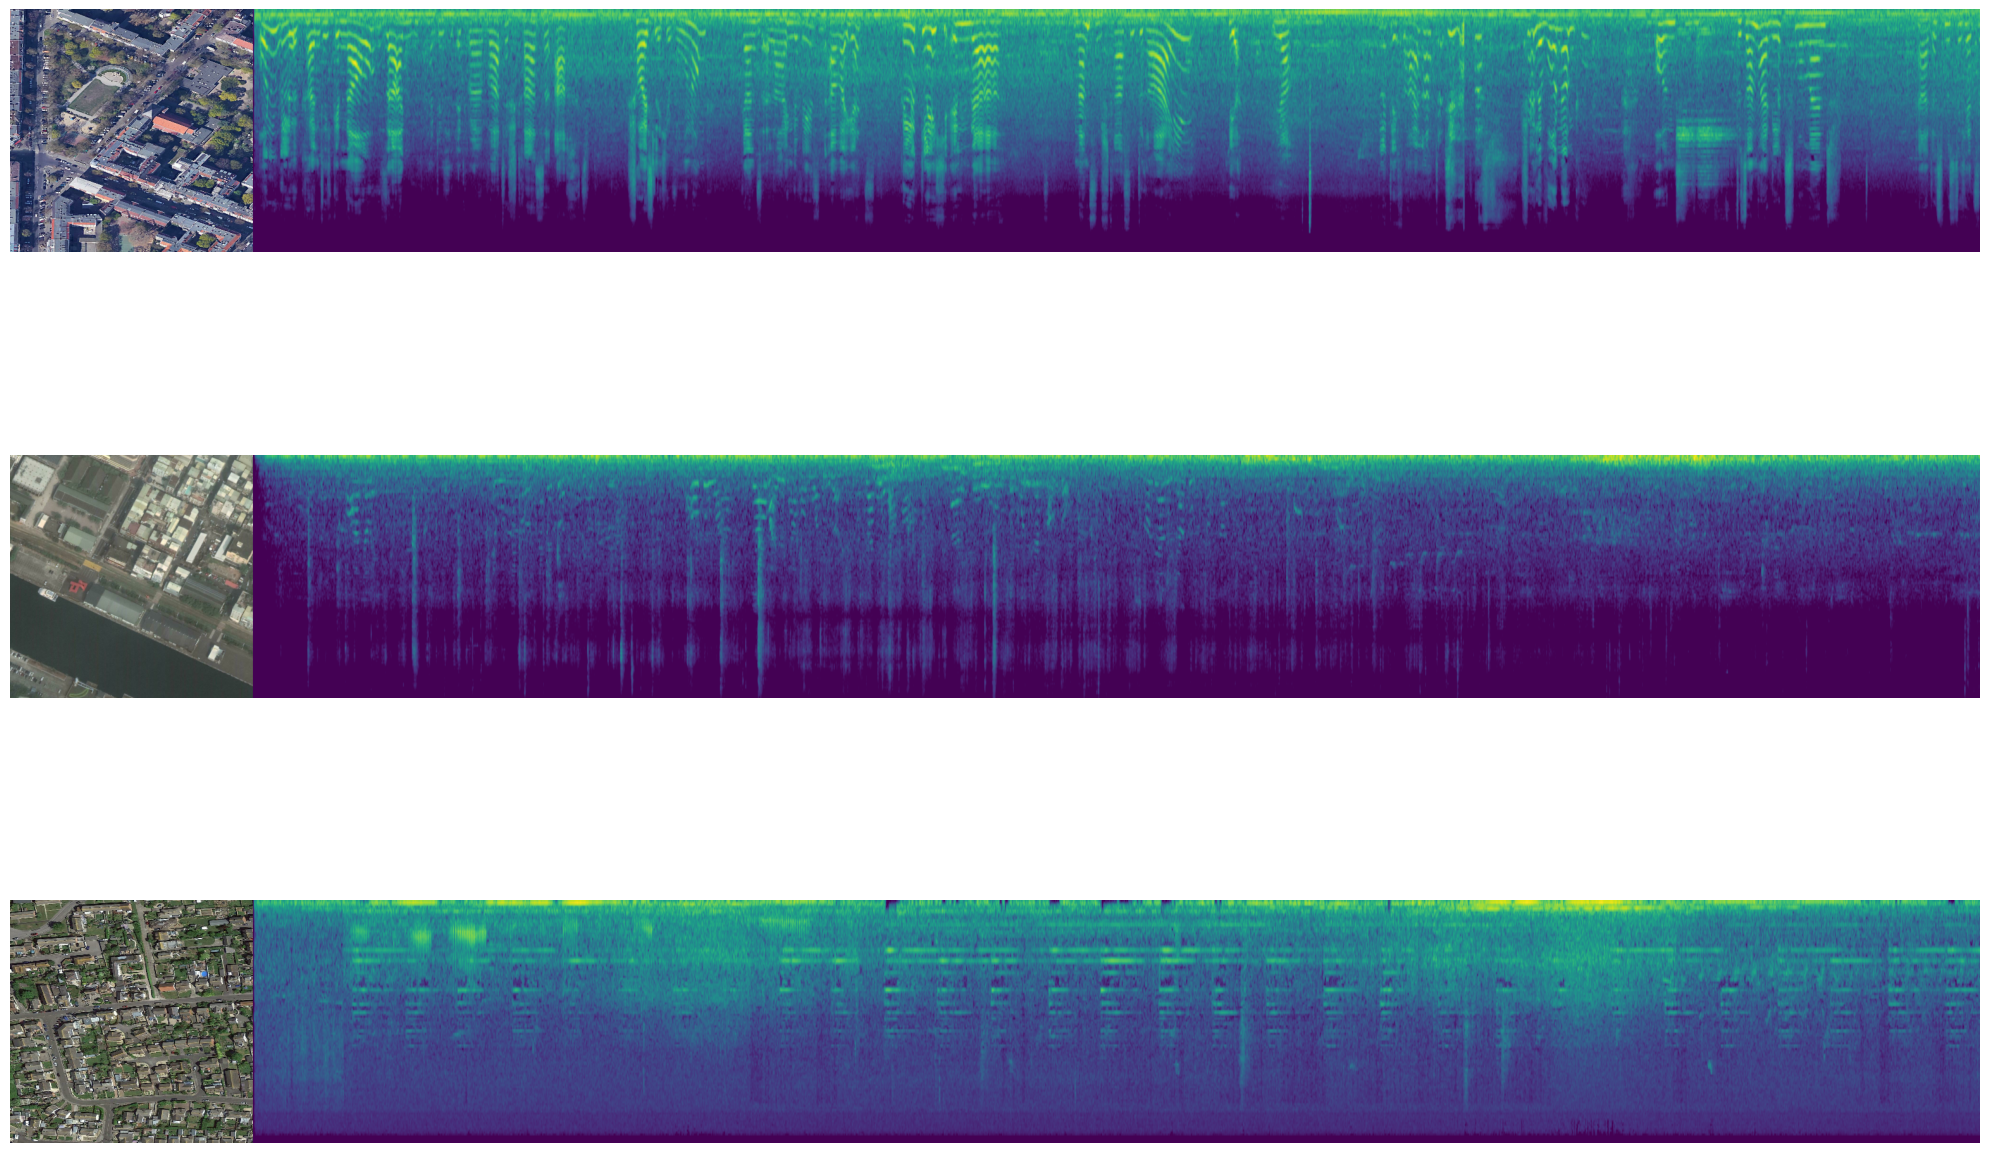

In [4]:
def plot_images_dls(dataloader_tup, num_images, spectro_den_b=True, sat_den_b=True):
    fig, axs = plt.subplots(nrows=num_images, ncols=1, figsize=(20, 5 * num_images))
    axs = axs.flatten()

    dataloader_spec, dataloader_sat = dataloader_tup  # Unpack the tuple

    image_count = 0
    for (spectrograms, label_spec, coords_spec), (sat_images, label_sat, coords_sat) in zip(dataloader_spec, dataloader_sat):
        for sat_image, spectrogram, label_sat, label_spec in zip(sat_images, spectrograms, label_sat, label_spec):
            if image_count >= num_images:
                            break

            if sat_den_b:
                sat_image = denormalize(sat_image, config.mean, config.std)
            if spectro_den_b:
                spectrogram = denormalize(spectrogram, config.mean, config.std)

            target_height = sat_image.shape[1]  
            spectrogram_resized = resize(spectrogram, (target_height, spectrogram.shape[-1]))

            combined_image = torch.cat((sat_image, spectrogram_resized), dim=2)  

            ax = axs[image_count]
            ax.imshow(combined_image.permute(1, 2, 0).numpy())  
            ax.axis('off')  

            image_count += 1

            # print labels of the combined image
            print(f'Spalte: {image_count%2}, Reihe{image_count//2}, Satellite: {label_sat}, Spectrogram: {label_spec}')

        if image_count >= num_images:
            break

    plt.tight_layout()
    plt.show()

plot_images_dls(dataloader_val_tup, 3,  spectro_den_b = True, sat_den_b = True)